In [97]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm as t
import sklearn.neighbors as sn
import numpy.matlib as ml
import skimage.transform as skt
from sklearn import svm
from sklearn.metrics import classification_report

## **Image Loading and Feature Extraction using Eigenvector**

In [98]:
datatrain = [];
labelTrain = [];

In [99]:
# Training Image Loader and Feature Extraction
for _classname in t.tqdm(range(1,7)):
    for _id in range(1,18):
        path = 'Char_Tr/Tr/' + str(_classname) + '/text (' + str(_id) + ').bmp';
        img = cv2.imread(path,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
        img = np.invert(img)
        datatrain.append(np.array(img).reshape(-1,1))
        labelTrain.append(_classname)
tmpShape = np.array(datatrain).shape;
datatrain = np.reshape(np.array(datatrain),(-1,tmpShape[1])).T

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 176.46it/s]


In [100]:
datatrain

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,  11,   0, 255],
       [255, 184, 255, ...,   0,   0,   0],
       [255,   0, 255, ...,   0,   0,   0]], dtype=uint8)

In [101]:
# 1 Mean Calculation
meanData = np.array(np.mean(datatrain,1));
meanVector = np.array(meanData).reshape((meanData.shape[0],-1));
data0mean = datatrain - meanVector;
tmp = np.array(meanData).reshape((meanData.shape[0],-1))

In [102]:
# 2 Covariance Matrix
cov = (1.0/(data0mean.shape[0]-1))*(np.dot(data0mean.T, data0mean));

In [103]:
# 3 Extract Eigenvector and Eigenvalue 
val, vec = np.linalg.eig(cov);
idx = val.argsort()[::-1] 
val = val[idx]
vec = vec[:,idx]

In [104]:
# 4 Define Number of Eigenvector
PCs = 10
SelectedVec = vec[:,0:PCs];

In [105]:
# 5 Training Feature Extraction by using first ten eigenvectors
EigenFace = np.dot(data0mean, SelectedVec);
featureTr = np.dot(EigenFace.T, data0mean);
featureTr = featureTr.T;
featureTr.shape

(102, 10)

In [106]:
# 6 Testing Feature Extraction by using first ten eigenvectors
path = 'Char_Tr/Tr/5/text (19).bmp';
img = cv2.imread(path,cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
tmpTs = np.array(img).reshape(-1,1)
featureTs = np.dot(EigenFace.T, tmpTs-meanVector).T;
labelTs = 6

## **Model Training**

In [107]:
# 7 Image Classification
clf = svm.SVC(kernel='linear')
# train SVM model
clf.fit(featureTr, labelTrain)
# classify by using SVM
out = clf.predict(featureTs)
print('Answer is ' + str(out))

Answer is [1]


## **Model Testing**

In [113]:
testfeature = []
testlabel = []

In [114]:
for _classname in t.tqdm(range(1,7)):
    for _id in range(18,21):
        path = 'Char_Tr/Tr/' + str(_classname) + '/text (' + str(_id) + ').bmp';
        img = cv2.imread(path,cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
        img = np.invert(img)
        tmpTs = np.array(img).reshape(-1,1)
        testfeature.append(np.dot(EigenFace.T, tmpTs-meanVector).T)
        testlabel.append(_classname)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 996.98it/s]


In [115]:
np.array(testfeature).shape

(18, 1, 10)

In [116]:
testfeature = np.reshape(np.array(testfeature),(18,-1))

In [118]:
clf.score(testfeature, testlabel)

0.9444444444444444

## **Predict Section**

In [119]:
#Change path of prediction here
path = 'Char_Tr/Tr/6/text (15).bmp';
img = cv2.imread(path,cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
img = np.invert(img)
tmpTs = np.array(img).reshape(-1,1)
featureTs = np.dot(EigenFace.T, tmpTs-meanVector).T;
labelTs = 2
out = clf.predict(featureTs)
print('The image is predicted as class ' + str(out))

The image is predicted as class [6]


## **Evaluation**

In [120]:
from sklearn.metrics import confusion_matrix

In [121]:
prediction = clf.predict(testfeature)

In [122]:
prediction

array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 3, 6, 6])

In [123]:
print(classification_report(testlabel, prediction))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3

    accuracy                           0.94        18
   macro avg       0.96      0.94      0.94        18
weighted avg       0.96      0.94      0.94        18



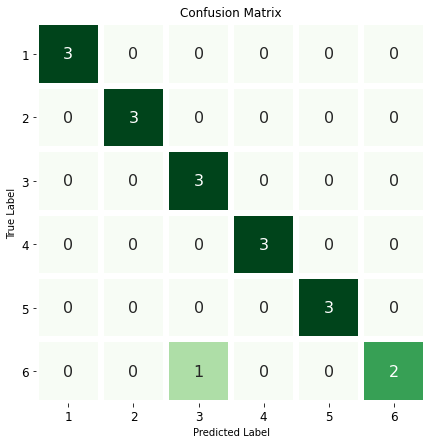

In [124]:
cm = confusion_matrix(testlabel, prediction)
df1 = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6], index= [1, 2, 3, 4, 5, 6], data= cm)
f,ax = plt.subplots(figsize=(7,7))


sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

## **TA Test Data**

In [125]:
tatest = []
talabel = []

In [126]:
from os import walk
mypath = 'textregtest/Tr/'
# f = []
for i in t.tqdm(range(1, 7)):
    for (dirpath, dirname, filenames) in walk(mypath + str(i)):
        for name in filenames:
            img = cv2.imread(mypath + str(i) + "/" + name,0)
            img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
            img = np.invert(img)
            tmpTs = np.array(img).reshape(-1,1)
            tatest.append(np.dot(EigenFace.T, tmpTs-meanVector).T)
            talabel.append(i)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.44it/s]


In [127]:
np.array(tatest).shape

(120, 1, 10)

In [128]:
tatest = np.reshape(np.array(tatest),(120,-1))

In [129]:
clf.score(tatest, talabel)

0.7166666666666667

## Prediction for One

In [130]:
mypath = 'textregtest/Tr/1/text (19).bmp'
img = cv2.imread(mypath,0)
img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
img = np.invert(img)
tmpTs = np.array(img).reshape(-1,1)
testOne = np.dot(EigenFace.T, tmpTs-meanVector).T;
out = clf.predict(testOne)
print('The image is predicted as class ' + str(out))

The image is predicted as class [1]


## Evaluation for TA Test

In [131]:
prediction_ta = clf.predict(tatest)

In [132]:
prediction_ta

array([1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 2, 2,
       3, 3, 2, 2, 1, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 4, 4, 4, 4, 3, 4, 5,
       3, 4, 5, 4, 5, 4, 4, 4, 4, 1, 4, 3, 4, 4, 5, 5, 3, 5, 5, 1, 5, 5,
       5, 5, 5, 5, 1, 5, 5, 1, 1, 5, 5, 1, 6, 6, 6, 1, 6, 6, 1, 6, 6, 1,
       3, 6, 6, 1, 6, 6, 3, 6, 1, 6])

In [133]:
print(classification_report(talabel, prediction_ta))

              precision    recall  f1-score   support

           1       0.48      0.75      0.59        20
           2       1.00      0.75      0.86        20
           3       0.55      0.80      0.65        20
           4       0.93      0.65      0.76        20
           5       0.78      0.70      0.74        20
           6       1.00      0.65      0.79        20

    accuracy                           0.72       120
   macro avg       0.79      0.72      0.73       120
weighted avg       0.79      0.72      0.73       120



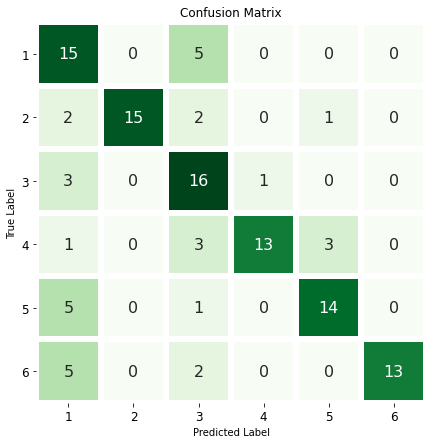

In [134]:
cm = confusion_matrix(talabel, prediction_ta)
df1 = pd.DataFrame(columns=[1, 2, 3, 4, 5, 6], index= [1, 2, 3, 4, 5, 6], data= cm)
f,ax = plt.subplots(figsize=(7,7))


sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()